In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import warnings
import os
import sys
import datetime as dt
import cartopy.crs as ccrs
#from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.ticker as mticker
#warnings.filterwarnings("ignore", category=RuntimeWarning) # ignore runtime warnings; here they arise from attempted operations on all-NaN arrays

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy12MHW/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
nl = dict(zip( ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2', 'CanESM5', 'GEM5.2-NEMO', 'GEM5-NEMO', 'CanCM4i-IC3',],
               [       11,                 11,         11,           11,              8,            9,        11,            11,          11,            11,])) 
modict={'Jacox':['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 
                        'NASA-GEOSS2S', 'NCEP-CFSv2'],
        'CanSIPSv2':['CanCM4i','GEM-NEMO'],
        'CanSIPSv21':['CanCM4i-IC3','GEM5-NEMO'],
        'CanSIPSv3':['CanESM5','GEM5.2-NEMO'],
        'GFDLNASA':[ 'GFDL-SPEAR','NASA-GEOSS2S'],}

In [3]:
basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
clim_years = [1991, 2020]
years=clim_years
mhwdir = basepath+'/mhw/detrended';
#f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{clim_years[0]}_{clim_years[-1]}.nc'
fobs=xr.open_dataset(f_obs)
mods=modict['CanSIPSv3']
il=2 #  months lead time
flist=[]
for modi in mods:
    if il<nl[modi]:
        # Load MHWs
        f_in = f'{mhwdir}/mhw_{modi}_l{il}_detrended_{clim_years[0]}_{clim_years[1]}.nc'
        flist.append(f_in)
ffor=xr.open_mfdataset(flist,chunks={'time':1,'X':-1,'Y':-1,'M':-1},concat_dim='M',combine='nested',data_vars='minimal',
                   coords='minimal',parallel=True,preprocess=lambda f: f.drop_vars(["sst_an_thr","mhw_prob"]))
M=40
mhwfor=ffor.is_mhw.data[:(-1*il),...].sum(axis=1)/M if il>0 else ffor.is_mhw.data.sum(axis=1)/M
mhwobs=fobs.is_mhw.data[il:,...]
lm=np.sum(fobs.is_mhw.data,axis=0)==0

In [4]:
# ice mask
f_ice=basepath+f'/OISST/oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
#with xr.open_dataset(f_ice) as fice:
fice=xr.open_dataset(f_ice)
icemask1=np.nanmax(fice.ice.data,axis=0)>0
Athresh=.50
Tthresh=.9
#Amax=np.zeros((20,)+np.shape(icemask1))
# for ind in range(0,20):
#     Amax[ind,...]=np.nanmax(fice.ice.data[12*ind:12*(ind+1),...],axis=0)
lost=np.where(fice.ice>Athresh,1,0).sum(axis=0)
#AmaxH=np.mean(np.where(Amax>0,1,0),axis=0)
imask=lost>(1-Tthresh)*np.shape(fice.ice)[0]

/tmp/reo000/792754/ipykernel_1824853/3439421695.py:5: RuntimeWarning: All-NaN slice encountered
  icemask1=np.nanmax(fice.ice.data,axis=0)>0


In [5]:
ffor

<xarray.Dataset> Size: 8GB
Dimensions:  (X: 360, Y: 181, S: 360, M: 40, Mon: 12)
Coordinates:
  * X        (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y        (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * M        (M) int64 320B 0 1 2 3 4 5 6 7 8 9 ... 11 12 13 14 15 16 17 18 19
  * S        (S) float32 1kB 372.0 373.0 374.0 375.0 ... 728.0 729.0 730.0 731.0
  * Mon      (Mon) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lon      (X) float32 1kB dask.array<chunksize=(360,), meta=np.ndarray>
    lat      (Y) float32 724B dask.array<chunksize=(181,), meta=np.ndarray>
    time     (S) float32 1kB dask.array<chunksize=(360,), meta=np.ndarray>
    year     (S) int64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
    month    (S) int64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
    is_mhw   (S, M, Y, X) float64 8GB dask.array<chunksize=(360, 20, 181, 360), meta=np.ndarray>

In [6]:
fobs

<xarray.Dataset> Size: 194MB
Dimensions:     (X: 360, Y: 181, S: 360, Mon: 12)
Coordinates:
  * X           (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y           (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * S           (S) float32 1kB 372.0 373.0 374.0 375.0 ... 729.0 730.0 731.0
  * Mon         (Mon) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lon         (X) float32 1kB ...
    lat         (Y) float32 724B ...
    time        (S) float32 1kB ...
    year        (S) int64 3kB ...
    month       (S) int64 3kB ...
    sst_an_thr  (Mon, Y, X) float64 6MB ...
    is_mhw      (S, Y, X) float64 188MB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0

In [7]:
float(ffor.lon[279])-360,float(ffor.lon[351])-360,float(ffor.lat[109]),float(ffor.lat[161])

(-81.0, -9.0, 19.0, 71.0)

In [8]:
mhwobs.shape

(358, 181, 360)

In [9]:
cmap=plt.get_cmap('Reds')
cmap.set_bad('w',alpha=0)

i0=275;i1=360;j0=109;j1=162

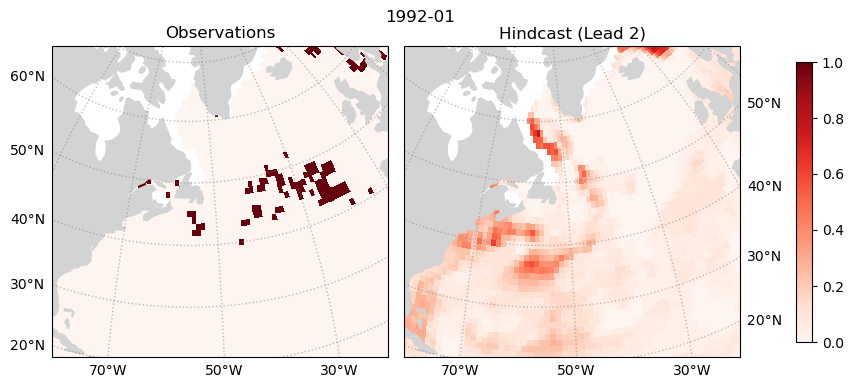

In [10]:
i=10


fig = plt.figure(figsize=[8, 4])
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(central_longitude=-56, central_latitude=44.7, globe=None))
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Orthographic(central_longitude=-56, central_latitude=44.7, globe=None))
axcb = fig.add_axes(rect=[.97,.15,.02,.7])
fig.subplots_adjust(bottom=0.05, top=0.95,left=0.04, right=0.9, wspace=0.05)
ax1.set_title('Observations')
ax2.set_title(f'Hindcast (Lead {il})')

for iax in (ax1,ax2):
    iax.set_extent([-80, -20, 20, 70], ccrs.PlateCarree())

date=dt.datetime(years[0]+int((i+il)/12),(i+il)%12+1,15)
fig.suptitle(f"{date.year}-{date.month:02}")
ax1.pcolormesh(fobs.lon.values,fobs.lat.values,np.ma.masked_where(imask|lm,mhwobs[i,...]),vmin=0,vmax=1,cmap=cmap,transform=ccrs.PlateCarree())
m=ax2.pcolormesh(fobs.lon.values,fobs.lat.values,np.ma.masked_where(imask|lm,mhwfor[i,...]),vmin=0,vmax=1,cmap=cmap,transform=ccrs.PlateCarree())
#ax1.pcolormesh(ffor.lon.values[i0:i1],ffor.lat.values[j0:j1],np.ma.masked_where(imask[j0:j1,i0:i1]|lm[j0:j1,i0:i1],mhwfor[i,j0:j1,i0:i1]),vmin=0,vmax=1,cmap=cmap,transform=ccrs.PlateCarree())
fig.colorbar(m,cax=axcb)

for iax in (ax1,ax2):
    iax.add_feature(cfeature.LAND,zorder=1,color='lightgray')
    gl = iax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlocator = mticker.FixedLocator([-90, -70, -50,-30,-10,10])
    gl.ylocator = mticker.FixedLocator([20, 30, 40, 50, 60,70])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if iax==ax1:
        gl.top_labels = False
        gl.right_labels = False
    elif iax==ax2:
        gl.top_labels = False
        gl.left_labels = False

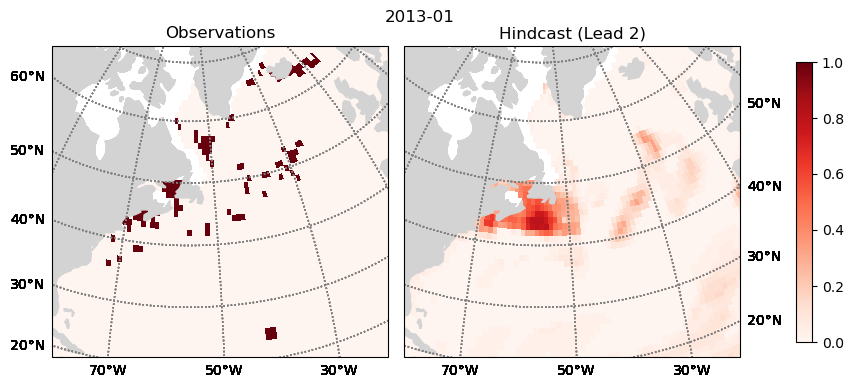

In [11]:
# Define the meta data for the movie
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='NAtl2012', artist='Matplotlib',
                comment='MHW')
writer = FFMpegWriter(fps=1, metadata=metadata)

cmap=plt.get_cmap('Reds')
cmap.set_bad('w',alpha=0)

i0=275;i1=360;j0=109;j1=162
fig = plt.figure(figsize=[8, 4])
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(central_longitude=-56, central_latitude=44.7, globe=None))
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Orthographic(central_longitude=-56, central_latitude=44.7, globe=None))
axcb = fig.add_axes(rect=[.97,.15,.02,.7])
fig.subplots_adjust(bottom=0.05, top=0.95,left=0.04, right=0.9, wspace=0.05)
ax1.set_title('Observations')
ax2.set_title(f'Hindcast (Lead {il})')
for iax in (ax1,ax2):
    iax.set_extent([-80, -20, 20, 70], ccrs.PlateCarree())

# Update the frames for the movie
with writer.saving(fig, "mhw_NAtl2012.mp4", dpi=100):
    for i in range(mhwobs.shape[0]):
        date=dt.datetime(years[0]+int((i+il)/12),(i+il)%12+1,15)
        if (date > dt.datetime(2011,12,1)) & (date < dt.datetime(2013,2,1)):
            fig.suptitle(f"{date.year}-{date.month:02}")
            ax1.pcolormesh(fobs.lon.values,fobs.lat.values,np.ma.masked_where(imask|lm,mhwobs[i,...]),vmin=0,vmax=1,cmap=cmap,transform=ccrs.PlateCarree())
            m=ax2.pcolormesh(fobs.lon.values,fobs.lat.values,np.ma.masked_where(imask|lm,mhwfor[i,...]),vmin=0,vmax=1,cmap=cmap,transform=ccrs.PlateCarree())
            #ax1.pcolormesh(ffor.lon.values[i0:i1],ffor.lat.values[j0:j1],np.ma.masked_where(imask[j0:j1,i0:i1]|lm[j0:j1,i0:i1],mhwfor[i,j0:j1,i0:i1]),vmin=0,vmax=1,cmap=cmap,transform=ccrs.PlateCarree())
            fig.colorbar(m,cax=axcb)
            
            for iax in (ax1,ax2):
                iax.add_feature(cfeature.LAND,zorder=1,color='lightgray')
                gl = iax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
                gl.xlocator = mticker.FixedLocator([-90, -70, -50,-30,-10,10])
                gl.ylocator = mticker.FixedLocator([20, 30, 40, 50, 60,70])
                gl.xformatter = LONGITUDE_FORMATTER
                gl.yformatter = LATITUDE_FORMATTER
                if iax==ax1:
                    gl.top_labels = False
                    gl.right_labels = False
                elif iax==ax2:
                    gl.top_labels = False
                    gl.left_labels = False
                    
            writer.grab_frame()

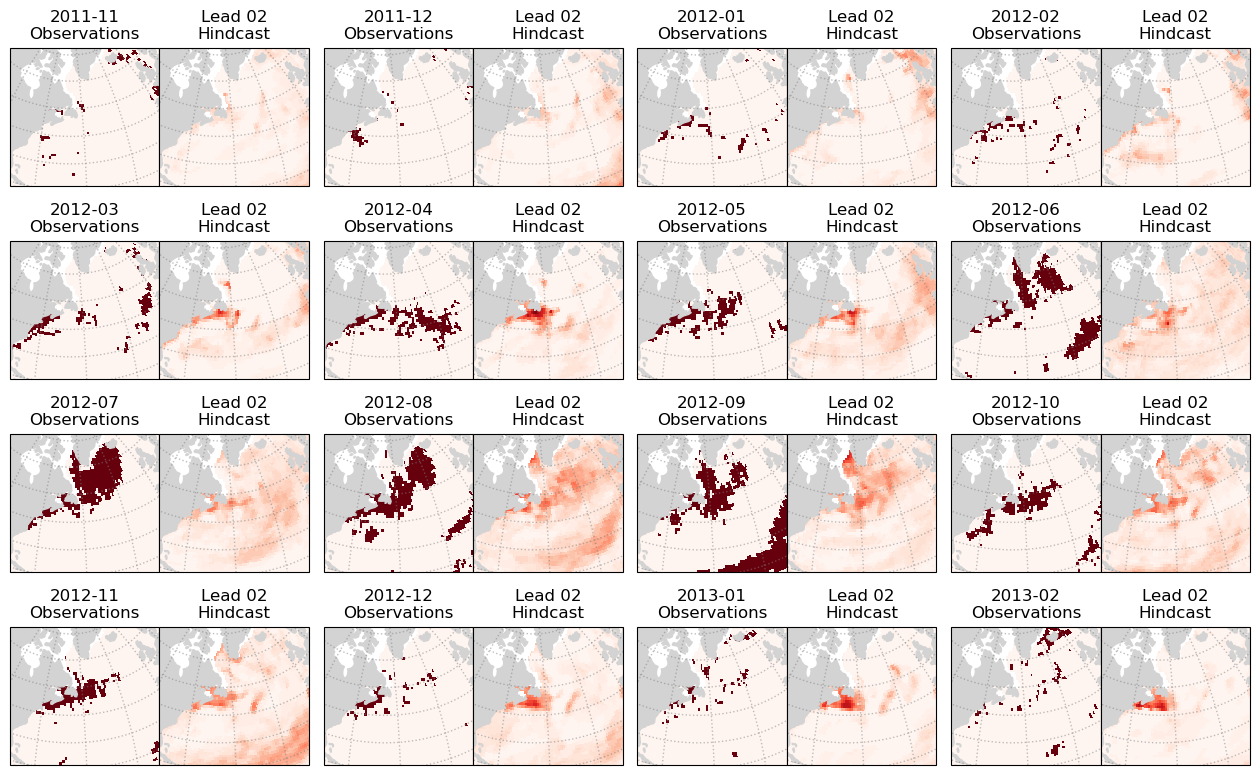

In [12]:
i0=275;i1=360;j0=109;j1=162

fig = plt.figure(figsize=(16,10))#constrained_layout=True,
gs = fig.add_gridspec(4, 4,wspace=.05,hspace=.01)

ii=0
for i in range(mhwobs.shape[0]):
    date=dt.datetime(years[0]+int((i+il)/12),(i+il)%12+1,15)
    if (date > dt.datetime(2011,11,1)) & (date < dt.datetime(2013,3,1)):
        igs=gs[ii]
        gss=igs.subgridspec(1,2,width_ratios=[1,1],wspace=0)
        ax1=fig.add_subplot(gss[0],projection=ccrs.Orthographic(central_longitude=-56, central_latitude=44.7, globe=None))
        ax2=fig.add_subplot(gss[1],projection=ccrs.Orthographic(central_longitude=-56, central_latitude=44.7, globe=None))
        #axcb=fig.add_subplot(gss[2])
        ax1.set_title(f"{date.year}-{date.month:02}\nObservations")
        ax2.set_title(f'Lead {il:02}\nHindcast')
        for iax in (ax1,ax2):
            iax.set_extent([-80, -20, 20, 70], ccrs.PlateCarree())
        ax1.pcolormesh(fobs.lon.values,fobs.lat.values,np.ma.masked_where(imask|lm,mhwobs[i,...]),vmin=0,vmax=1,cmap=cmap,transform=ccrs.PlateCarree())
        m=ax2.pcolormesh(fobs.lon.values,fobs.lat.values,np.ma.masked_where(imask|lm,mhwfor[i,...]),vmin=0,vmax=1,cmap=cmap,transform=ccrs.PlateCarree())
        #fig.colorbar(m,cax=axcb)
        
        for iax in (ax1,ax2):
            iax.add_feature(cfeature.LAND,zorder=1,color='lightgray')
            gl = iax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, 
                              linewidth=1, color='gray', alpha=0.5, linestyle=':')
            gl.xlocator = mticker.FixedLocator([-90, -70, -50,-30,-10,10])
            gl.ylocator = mticker.FixedLocator([20, 30, 40, 50, 60,70])
            # gl.xformatter = LONGITUDE_FORMATTER
            # gl.yformatter = LATITUDE_FORMATTER
            # if iax==ax1:
            #     gl.top_labels = False
            #     gl.right_labels = False
            # elif iax==ax2:
            #     gl.top_labels = False
            #     gl.left_labels = False
        ii=ii+1


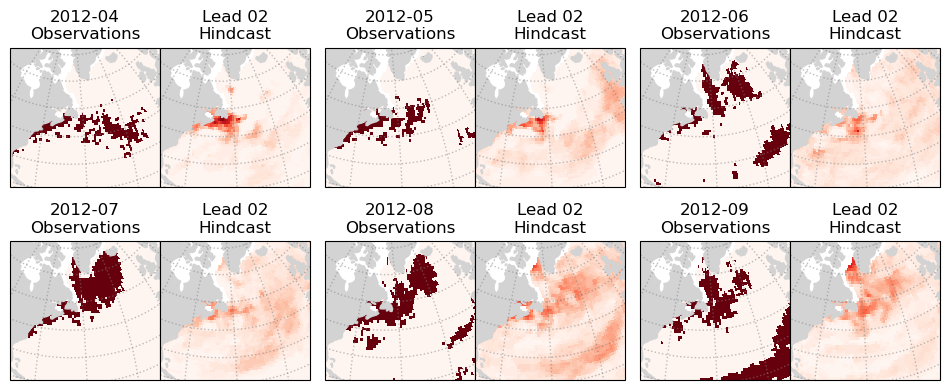

In [13]:
i0=275;i1=360;j0=109;j1=162

fig = plt.figure(figsize=(12,5))#constrained_layout=True,
gs = fig.add_gridspec(2, 3,wspace=.05,hspace=.01)

ii=0
for i in range(mhwobs.shape[0]):
    date=dt.datetime(years[0]+int((i+il)/12),(i+il)%12+1,15)
    if (date > dt.datetime(2012,4,1)) & (date < dt.datetime(2012,10,1)):
        igs=gs[ii]
        gss=igs.subgridspec(1,2,width_ratios=[1,1],wspace=0)
        ax1=fig.add_subplot(gss[0],projection=ccrs.Orthographic(central_longitude=-56, central_latitude=44.7, globe=None))
        ax2=fig.add_subplot(gss[1],projection=ccrs.Orthographic(central_longitude=-56, central_latitude=44.7, globe=None))
        #axcb=fig.add_subplot(gss[2])
        ax1.set_title(f"{date.year}-{date.month:02}\nObservations")
        ax2.set_title(f'Lead {il:02}\nHindcast')
        for iax in (ax1,ax2):
            iax.set_extent([-80, -20, 20, 70], ccrs.PlateCarree())
        ax1.pcolormesh(fobs.lon.values,fobs.lat.values,np.ma.masked_where(imask|lm,mhwobs[i,...]),vmin=0,vmax=1,cmap=cmap,transform=ccrs.PlateCarree())
        m=ax2.pcolormesh(fobs.lon.values,fobs.lat.values,np.ma.masked_where(imask|lm,mhwfor[i,...]),vmin=0,vmax=1,cmap=cmap,transform=ccrs.PlateCarree())
        #fig.colorbar(m,cax=axcb)
        
        for iax in (ax1,ax2):
            iax.add_feature(cfeature.LAND,zorder=1,color='lightgray')
            gl = iax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, 
                              linewidth=1, color='gray', alpha=0.5, linestyle=':')
            gl.xlocator = mticker.FixedLocator([-90, -70, -50,-30,-10,10])
            gl.ylocator = mticker.FixedLocator([20, 30, 40, 50, 60,70])
            # gl.xformatter = LONGITUDE_FORMATTER
            # gl.yformatter = LATITUDE_FORMATTER
            # if iax==ax1:
            #     gl.top_labels = False
            #     gl.right_labels = False
            # elif iax==ax2:
            #     gl.top_labels = False
            #     gl.left_labels = False
        ii=ii+1
